# BotArtist Dataset

**Hard facts:**
- Collection period: 2022 – early 2023
- Domain: Russo-Ukrainian war (Twitter/X)
- Size: ~10.9M user profiles
- Labels: *bot* vs *human* (machine-predicted, not human verified)
- Features: activity metrics (statuses, followers, following), normalized ratios (per age), profile features (name/description entropy, digit %), metadata (verified, protected, profile image)
- Keywords/hashtags used for collection: `#Ukraine`, `#UkraineWar`, `#StopRussia`, `#StandWithUkraine`, `#Russia`, `#Putin`, `#Zelenskyy`, as well as terms like *Ukraine war*, *Russia invasion*, *Donbas*, *Kyiv*, *Moscow*, *NATO*
- Domains included: news and war-related sources such as `rt.com`, `t.me` (Telegram), `bbc.com/ukraine`, `pravda.com.ua`

**Description:**
The BotArtist dataset was created to study bot activity around the Russo-Ukrainian war. Accounts were collected via the Twitter API v2 using war-related keywords, hashtags, and domains. Labels were generated using the BotArtist classifier, trained on prior bot detection datasets (e.g., Botometer, TwiBot). While very large and feature-rich, its labels rely on machine predictions and should be treated as weak supervision rather than ground truth.

**Source:** [Zenodo](https://zenodo.org/records/11203900), [ArXiv](https://arxiv.org/abs/2306.00037)


## Features
### Account Age & Activity

* age: Account lifetime in days since creation.
* statuses	- Total number of tweets/posts.
* statuses_by_age	- Average posts per day (statuses ÷ age).
* following	- Number of other accounts this user follows.
* following_by_age	- Average new follows per day.
* followers	- Number of followers the account has.
* followers_by_age	- Average new followers gained per day.
* listed	- Number of public Twitter lists the account is added to.
* listed_by_age	- List additions normalized by account age.
* foll_friends	- Ratio of followers to following — common bot indicator (very high or low ratios can be suspicious).

### Profile Metadata
* profile_image	Whether the user has a custom profile image (1) or the default one (0).
* has_location	Whether the user filled out the “location” field.
* profile_url	Whether a URL is included in the profile (1/0).
* verified	Verified (blue check) account status.
* protected	Whether the account’s tweets are protected/private.

### Text Composition Features
* description_urls	Number of URLs found in the profile description.
* description_mentions	Number of @mentions found in the description.
* description_hashtags	Number of hashtags # in the description.
* description_upper_len	Count of uppercase characters in description.
* description_lower_len	Count of lowercase characters in description.
* description_digit_len	Count of digits in description.
* description_spec_len	Count of special characters in description.
* description_upper_pcnt	% of uppercase characters.
* description_lower_pcnt	% of lowercase characters.
* description_digit_pcnt	% of digits.
* description_spec_pcnt	% of special characters.
* description_len	Total length of the description.

### Screen Name
* screen_name_upper_len	Count of uppercase characters in username.
* screen_name_lower_len	Count of lowercase characters in username.
* screen_name_digit_len	Count of digits in username.
* screen_name_spec_len	Count of special characters in username.
* screen_name_upper_pcnt	% uppercase.
* screen_name_lower_pcnt	% lowercase.
* screen_name_digit_pcnt	% digits.
* screen_name_spec_pcnt	% special chars.
* screen_name_len	Username length.
* screen_name_sim	Similarity between screen name and display name (e.g., using normalized Levenshtein distance) — high similarity often means authentic user.
* screen_name_entropy	Shannon entropy of screen name — randomness measure; higher can indicate autogenerated handles.

### Display Name
* name_upper_len, name_lower_len, name_digit_len, name_spec_len	Counts of uppercase/lowercase/digit/special characters.
* name_upper_pcnt, name_lower_pcnt, name_digit_pcnt, name_spec_pcnt	Percentages of those character types.
* name_len	Total display name length.
* name_entropy	Shannon entropy of name — measures character randomness.

### URL
* total_urls	Total number of URLs associated with the user (e.g., from tweets or description).
* description_urls / profile_url	Whether profile description or profile has URLs.

### Targets
* uid	Unique user identifier (kept for joining, not for modeling).
* label	Target variable (bot / human).
* proba	(Sometimes included) — Predicted probability from BotArtist’s weak classifier; used as weak supervision source, not for training your model directly.

## Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

#from utils.data_prepping import outlier_summary

In [169]:
import importlib
from utils import data_prepping
importlib.reload(data_prepping)

from utils.data_prepping import plot_threshold, evaluate_model, plot_confusion

In [6]:
df = pd.read_csv("data/1_BotArtist/russo-ukrainian-war-10M-profiles.csv")

In [7]:
original = df.copy()

In [8]:
print("Shape of dataset:", df.shape)
df.head(20)


Shape of dataset: (10929533, 52)


,age,description_urls,description_mentions,description_hashtags,screen_name_sim,statuses,statuses_by_age,following,following_by_age,followers,...,name_entropy,has_location,profile_url,total_urls,foll_friends,verified,protected,uid,label,proba
0,786.0,0,0,0,0.200000,1215,1.545802,258,0.328244,80,...,2.271869,1,1,1,0.310078,0,0,uidb46b767fa5e2d342baaf2fc457a8740e3822837cd22...,human,68
1,4722.0,0,0,0,0.333333,3332,0.705633,49771,10.540237,128211,...,1.609438,0,0,0,2.576018,0,0,uidc43ed59435d39c26a0a3e972241710175492d68024e...,human,66
2,3410.0,0,0,0,0.411765,178614,52.379472,95,0.027859,1642,...,2.441015,1,0,0,17.284211,0,0,uida3eabc8386c783711bca4076378810ab5396082a6e0...,human,99
3,4266.0,2,0,0,0.857143,207601,48.664088,8,0.001875,3911749,...,2.302585,1,1,3,488968.625000,1,0,uidde3a6fd227120315235df6807eb63b035159a98b771...,human,99
4,2083.0,0,0,0,0.692308,1271,0.610178,138,0.066251,30,...,2.351673,0,0,0,0.217391,0,0,uid9dcc848e0b07d43d9df616f4969c72d84d863c34e88...,bot,54
5,5224.0,0,3,0,0.416667,27539,5.271631,1394,0.266845,2006632,...,2.484367,1,1,1,1439.477762,1,0,uid2991f96db7414c07aa693416ab33b61e42e80b155ff...,human,99
6,870.0,0,0,0,0.307692,2331,2.679310,325,0.373563,152,...,2.197225,1,0,0,0.467692,0,0,uida01bd6e0b465dd11cee30a0f557de3ef19d2a89eb8c...,human,95
7,1239.0,1,2,0,1.000000,33541,27.071025,5,0.004036,2514015,...,2.025326,1,1,2,502803.000000,1,0,uid12f2f7b396da805b7886496822ea8c59ae54399bf65...,human,99
8,1328.0,0,0,0,0.000000,10589,7.973645,318,0.239458,193,...,2.523211,1,1,1,0.606918,0,0,uidce1770603129fa04acead7cd418ef332f0eda9c4976...,human,93
9,1127.0,1,0,1,0.266667,1728,1.533274,44,0.039042,15908,...,2.532591,1,1,2,361.545455,0,0,uid8d373f6484a5f7c4d2c3b4b300f5cb2dbd5aab4108e...,human,91


## EDA

In [9]:
df.info()

missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10929533 entries, 0 to 10929532
Data columns (total 52 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   age                     float64
 1   description_urls        int64  
 2   description_mentions    int64  
 3   description_hashtags    int64  
 4   screen_name_sim         float64
 5   statuses                int64  
 6   statuses_by_age         float64
 7   following               int64  
 8   following_by_age        float64
 9   followers               int64  
 10  followers_by_age        float64
 11  listed                  int64  
 12  listed_by_age           float64
 13  profile_image           int64  
 14  description_upper_len   int64  
 15  description_lower_len   int64  
 16  description_digit_len   int64  
 17  description_spec_len    int64  
 18  description_upper_pcnt  float64
 19  description_lower_pcnt  float64
 20  description_digit_pcnt  float64
 21  description_spec_pcnt   float

In [10]:
print("\nSummary statistics:")
print(df.describe().T)


Summary statistics:
                             count          mean            std   min  \
age                     10929533.0  1.985266e+03    1647.581753   0.0   
description_urls        10929533.0  4.246815e-02       0.247713   0.0   
description_mentions    10929533.0  8.819407e-03       0.155272   0.0   
description_hashtags    10929533.0  2.414037e-02       0.339279   0.0   
screen_name_sim         10929533.0  4.476854e-01       0.300895   0.0   
statuses                10929533.0  1.411933e+04   44191.322833   0.0   
statuses_by_age         10929533.0  1.172147e+01      43.407355   0.0   
following               10929533.0  7.760640e+02    3361.368815   0.0   
following_by_age        10929533.0  1.780805e+00      11.045350   0.0   
followers               10929533.0  3.286531e+03  182082.271002   0.0   
followers_by_age        10929533.0  2.108980e+00     800.942224   0.0   
listed                  10929533.0  1.627956e+01     389.508591   0.0   
listed_by_age           109295

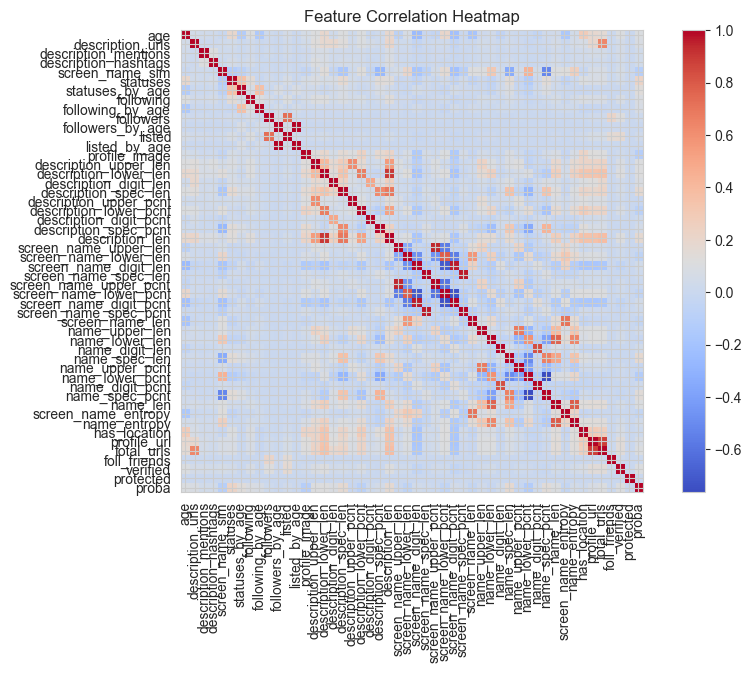

In [11]:
#Correlations
num_cols = df.select_dtypes(include="number").columns
corr = df[num_cols].corr()
plt.figure(figsize=(10, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
print(corr)

                             age  description_urls  description_mentions  \
age                     1.000000          0.043063              0.032937   
description_urls        0.043063          1.000000              0.013967   
description_mentions    0.032937          0.013967              1.000000   
description_hashtags    0.022752          0.009903              0.108164   
screen_name_sim        -0.010071          0.026211              0.016573   
statuses                0.199556          0.038894              0.028263   
statuses_by_age        -0.127959          0.004152              0.007205   
following               0.095239          0.034032              0.030657   
following_by_age       -0.151648         -0.001025              0.000123   
followers               0.021279          0.013811              0.019015   
followers_by_age       -0.000682          0.001321              0.001110   
listed                  0.053534          0.034126              0.032187   
listed_by_ag

Class counts:
 label
human    6707355
bot      4222178
Name: count, dtype: int64

Class percentages:
 label
human    61.37
bot      38.63
Name: proportion, dtype: float64


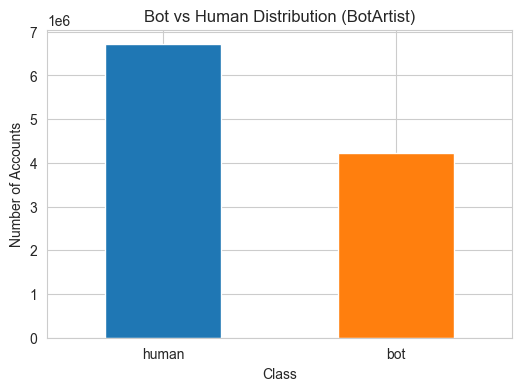

In [13]:
class_counts = df["label"].value_counts()
class_perc = df["label"].value_counts(normalize=True) * 100

print("Class counts:\n", class_counts)
print("\nClass percentages:\n", class_perc.round(2))

plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e"])
plt.title("Bot vs Human Distribution (BotArtist)")
plt.xlabel("Class")
plt.ylabel("Number of Accounts")
plt.xticks(rotation=0)
plt.show()

In [14]:
#Plot list
features_to_plot = [
    ("followers", "Followers Count"),
    ("following", "Following Count"),
    ("foll_friends", "Follower/Following Ratio"),
    ("statuses", "Statuses (Posts)"),
    ("statuses_by_age", "Posts per Day Online"),
    ("followers_by_age", "Followers per Day Online"),
    ("following_by_age", "Following per Day Online"),
    ("age", "Age of Accounts (in days)")
]

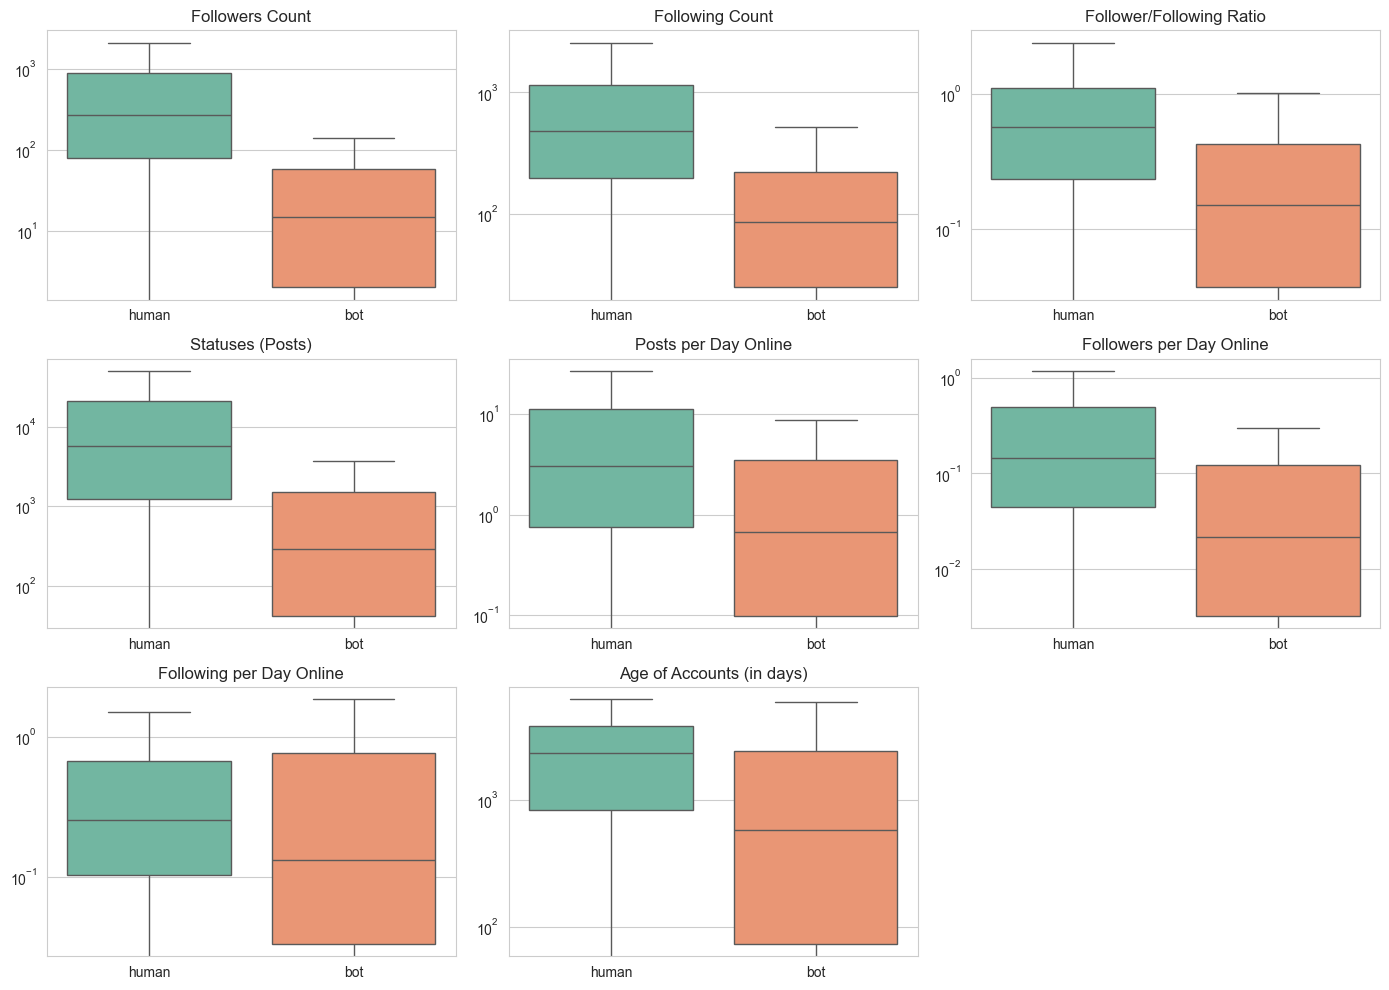

In [15]:
# Boxplots
plt.figure(figsize=(14, 10))
for i, (col, label) in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(
    data=df,
    x="label",
    y=col,
    hue="label",
    showfliers=False,
    palette="Set2",
    legend=False
    )
    plt.yscale("log")
    plt.title(label)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

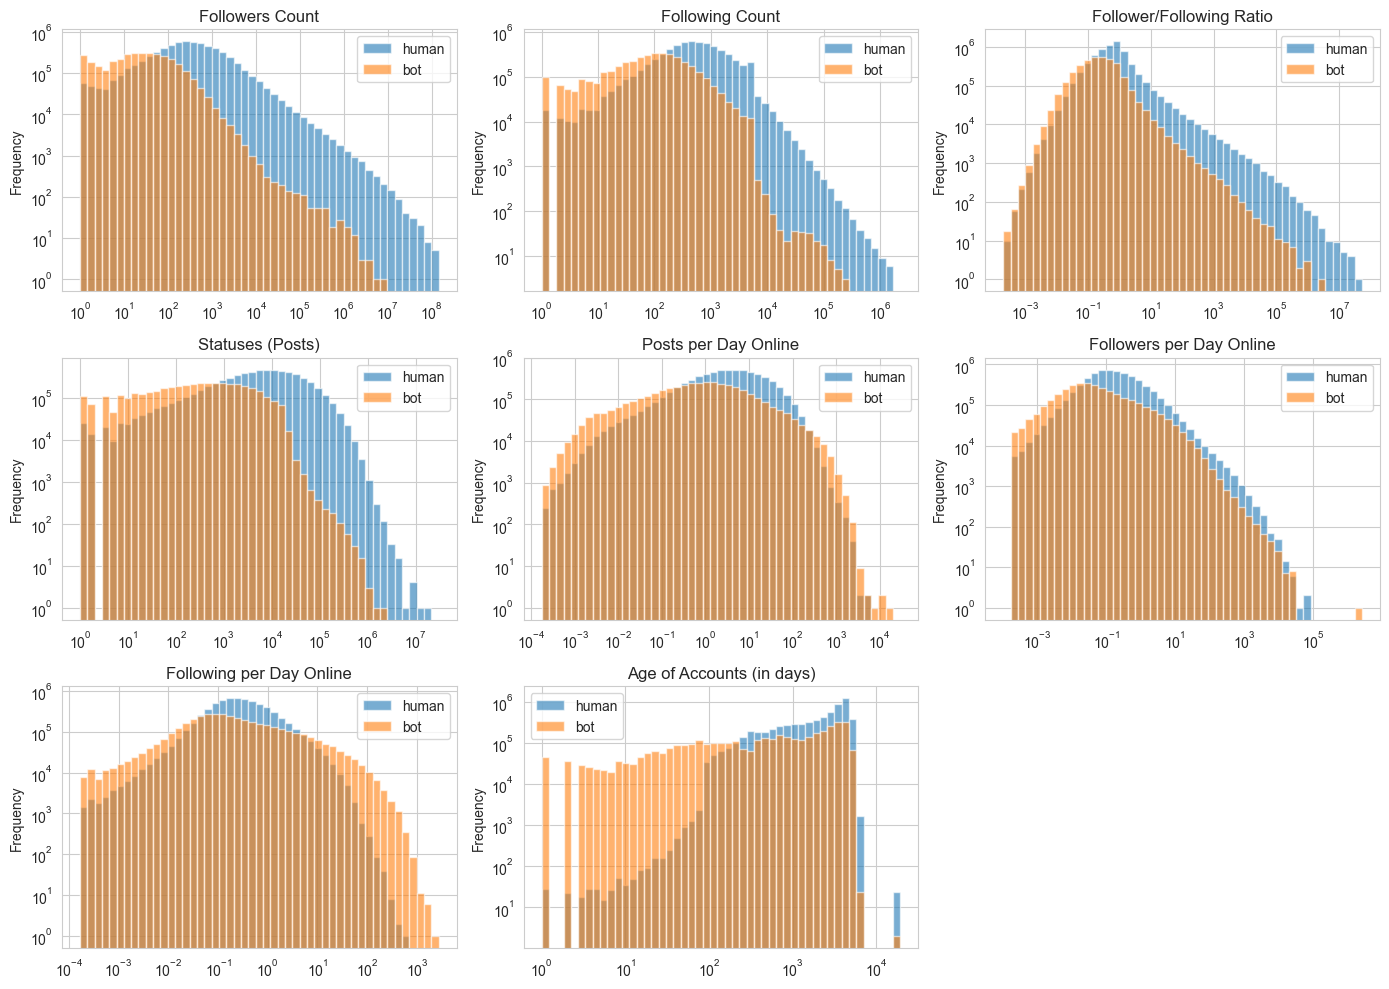

In [16]:
plt.figure(figsize=(14, 10))
for i, (col, label) in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)

    values = df[col][df[col] > 0]

    bins = np.logspace(np.log10(values.min()), np.log10(values.max()), 50)

    #histogram
    for lbl, color in zip(df["label"].unique(), ["#1f77b4", "#ff7f0e"]):
        subset = df[df["label"] == lbl][col]
        plt.hist(
            subset[subset > 0],
            bins=bins,
            alpha=0.6,
            label=lbl,
            color=color
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.title(label)
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

In [25]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Reclassify binary (only 0/1 or NaN)
binary_like = []
for col in num_cols:
    unique_vals = df[col].dropna().unique()
    if set(unique_vals).issubset({0, 1}):
        binary_like.append(col)

# num_cols → cat_cols
for col in binary_like:
    num_cols.remove(col)
    cat_cols.append(col)

# Summary DataFrame
feature_counts = pd.DataFrame({
    "Feature Type": ["Numerical", "Categorical"],
    "Count": [len(num_cols), len(cat_cols)],
    "Names": [num_cols, cat_cols]
})

print(feature_counts)


  Feature Type  Count                                              Names
0    Numerical     45  [age, description_urls, description_mentions, ...
1  Categorical      7  [uid, label, profile_image, has_location, prof...


## Preprocessing

In [86]:
df = original

In [99]:
# --- 1. Convert binary 0/1 columns to bool ---
binary_cols = ["profile_image", "has_location", "profile_url", "verified", "protected"]
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

# --- 2. Encode label ---
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])  # bot=0, human=1

# --- 3. Set UID as index ---
if "uid" in df.columns:
    df = df.set_index("uid", drop=True)

# --- 4. Separate features and target ---
drop_cols = ["label", "proba"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["label"]
prob = df["proba"]

prob.index = prob.index.astype(str).str.strip()
prob.name = 'P_botartist'
prob = prob / 100.0

# Ensure both share the same index (uid)
assert X.index.equals(y.index), "Index mismatch between X and y!"
assert X.index.equals(prob.index), "Index mismatch between X and y!"

print(f"X shape: {X.shape}, y shape: {y.shape} proba shape: {prob.shape}")
print("Positive class ratio:", y.mean().round(4))
print("X Index name:", X.index.name)
print("Y Index name:", y.index.name)
print("Prob Index name:", prob.index.name)


X shape: (10929533, 49), y shape: (10929533,) proba shape: (10929533,)
Positive class ratio: 0.6137
X Index name: uid
Y Index name: uid
Prob Index name: uid


In [89]:
X.head()

,age,description_urls,description_mentions,description_hashtags,screen_name_sim,statuses,statuses_by_age,following,following_by_age,followers,...,name_spec_pcnt,name_len,screen_name_entropy,name_entropy,has_location,profile_url,total_urls,foll_friends,verified,protected
uid,,,,,,,,,,,,,,,,,,,,,
uidb46b767fa5e2d342baaf2fc457a8740e3822837cd22c4b7300b166000cf9fa0f,786.0,0,0,0,0.200000,1215,1.545802,258,0.328244,80,...,0.090909,11,2.138333,2.271869,True,True,1,0.310078,False,False
uidc43ed59435d39c26a0a3e972241710175492d68024e40e1e1f729dd67c03f0be,4722.0,0,0,0,0.333333,3332,0.705633,49771,10.540237,128211,...,0.000000,5,1.889159,1.609438,False,False,0,2.576018,False,False
uida3eabc8386c783711bca4076378810ab5396082a6e07cfca60c8ebc7805429e8,3410.0,0,0,0,0.411765,178614,52.379472,95,0.027859,1642,...,0.000000,14,2.441015,2.441015,True,False,0,17.284211,False,False
uidde3a6fd227120315235df6807eb63b035159a98b771a9e3550187823c0d16da7,4266.0,2,0,0,0.857143,207601,48.664088,8,0.001875,3911749,...,0.100000,10,1.735126,2.302585,True,True,3,488968.625000,True,False
uid9dcc848e0b07d43d9df616f4969c72d84d863c34e883fc1fb88e8c8593df6050,2083.0,0,0,0,0.692308,1271,0.610178,138,0.066251,30,...,0.076923,13,2.523211,2.351673,False,False,0,0.217391,False,False


In [90]:
y.head()

uid
uidb46b767fa5e2d342baaf2fc457a8740e3822837cd22c4b7300b166000cf9fa0f    1
uidc43ed59435d39c26a0a3e972241710175492d68024e40e1e1f729dd67c03f0be    1
uida3eabc8386c783711bca4076378810ab5396082a6e07cfca60c8ebc7805429e8    1
uidde3a6fd227120315235df6807eb63b035159a98b771a9e3550187823c0d16da7    1
uid9dcc848e0b07d43d9df616f4969c72d84d863c34e883fc1fb88e8c8593df6050    0
Name: label, dtype: int64

In [91]:
prob.head()

uid
uidb46b767fa5e2d342baaf2fc457a8740e3822837cd22c4b7300b166000cf9fa0f    68
uidc43ed59435d39c26a0a3e972241710175492d68024e40e1e1f729dd67c03f0be    66
uida3eabc8386c783711bca4076378810ab5396082a6e07cfca60c8ebc7805429e8    99
uidde3a6fd227120315235df6807eb63b035159a98b771a9e3550187823c0d16da7    99
uid9dcc848e0b07d43d9df616f4969c72d84d863c34e883fc1fb88e8c8593df6050    54
Name: proba, dtype: int64

## Splitting

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Confirm index consistency
print("Train index name:", X_train.index.name)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train index name: uid
Train: (9836579, 49), Test: (1092954, 49)


# Models
## HIST GRADIENT BOOST
### Training

In [93]:
clf = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=500,
    random_state=42
)

w_train = compute_sample_weight(class_weight="balanced", y=y_train)
clf.fit(X_train, y_train, sample_weight=w_train)

,loss,'log_loss'
,learning_rate,0.05
,max_iter,500
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


### Evaluation

In [148]:
p_test_hgb = clf.predict_proba(X_test)[:, 1]
metrics_hgb = evaluate_model(y_test, p_test_hgb)

ROC-AUC: 0.9864 | PR-AUC: 0.9913 | F1@0.399: 0.9495 | ACC: 0.9374


In [150]:
results_hgb = (
    pd.DataFrame({"P_bot": p_test_hgb}, index=X_test.index.astype(str).str.strip())
    .assign(y_true=y_test.values, y_pred=(p_test_hgb >= metrics_hgb["best_thr"]).astype(int))
)
results_hgb = results_hgb.join(prob, how="left")

results_hgb.head()

,P_bot,y_true,y_pred,P_botartist
uid,,,,
uid8ff7d8a9497e61db3e3580321e91c9aa2ae4cff5c2e13b90a33a75b44a555a60,0.997770,1,1,9.800000e-07
uid41097f1d660cea56c86ff4e55a7fe39584be5a478ed575b037dffb25a0968d20,0.431525,1,1,7.300000e-07
uid824a7df18f17ac96e997b84aa0634e8f37e03a3ca662f1721a5614ae56c4aa6b,0.000055,0,0,9.900000e-07
uid844757b73d0920884725110208b4d645ab1ffad0d38959173125dae5b3dc06e7,0.942146,1,1,9.400000e-07
uidf951e43c2f96f58b7570af624001dc8428992077d85ce51f58b0145c4147527d,0.009784,0,0,9.400000e-07


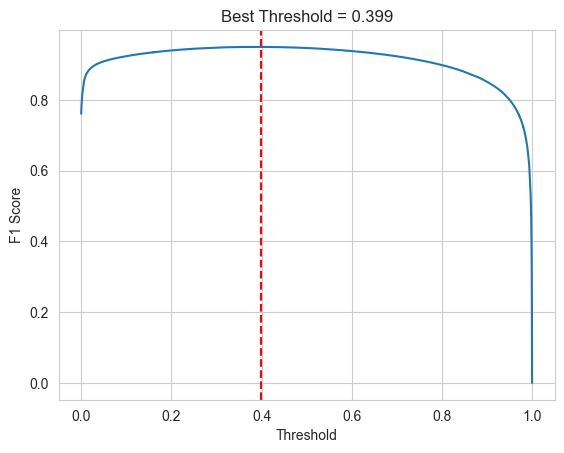

In [170]:
plot_threshold(metrics_hgb["thr"], metrics_hgb["best_thr"], metrics_hgb["f1s"])

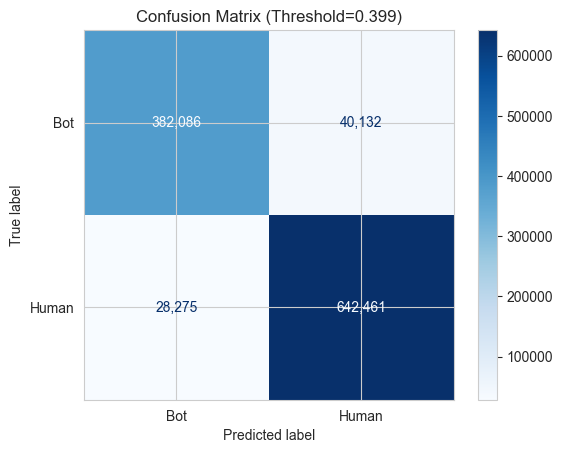

True Negatives: 382086
False Positives: 40132
False Negatives: 28275
True Positives: 642461


In [154]:
plot_confusion(y_test, metrics_hgb["y_pred"], metrics_hgb["best_thr"])

## Lightgbm

In [107]:
from lightgbm import LGBMClassifier
# === Train ===
lgb = LGBMClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    objective="binary",
    random_state=42
)

lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6036619, number of negative: 3799960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.374438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6180
[LightGBM] [Info] Number of data points in the train set: 9836579, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM -> ROC-AUC: 0.0079 | PR-AUC: 0.4040 | F1@0.399: 0.0777


In [157]:
# === Predict ===
p_test_lgb = lgb.predict_proba(X_test)[:, 1]
metrics_lgb = evaluate_model(y_test, p_test_lgb)

ROC-AUC: 0.9921 | PR-AUC: 0.9951 | F1@0.393: 0.9638 | ACC: 0.9553


In [158]:
results_lgb = (
    pd.DataFrame({"P_bot": p_test_lgb}, index=X_test.index)
    .assign(
        y_true=y_test.values,
        y_pred=(p_test_lgb >= metrics_lgb["best_thr"]).astype(int)
    )
)

results_lgb = results_lgb.join(prob, how="left")

results_lgb.head()

,P_bot,y_true,y_pred,P_botartist
uid,,,,
uid8ff7d8a9497e61db3e3580321e91c9aa2ae4cff5c2e13b90a33a75b44a555a60,9.998858e-01,1,1,9.800000e-07
uid41097f1d660cea56c86ff4e55a7fe39584be5a478ed575b037dffb25a0968d20,9.231082e-01,1,1,7.300000e-07
uid824a7df18f17ac96e997b84aa0634e8f37e03a3ca662f1721a5614ae56c4aa6b,1.392469e-08,0,0,9.900000e-07
uid844757b73d0920884725110208b4d645ab1ffad0d38959173125dae5b3dc06e7,9.795492e-01,1,1,9.400000e-07
uidf951e43c2f96f58b7570af624001dc8428992077d85ce51f58b0145c4147527d,1.413889e-03,0,0,9.400000e-07


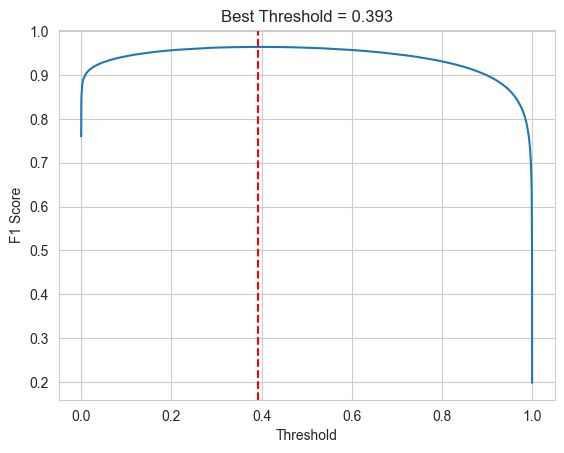

In [159]:
plot_threshold(metrics_lgb["thr"], metrics_lgb["best_thr"], metrics_lgb["f1s"])

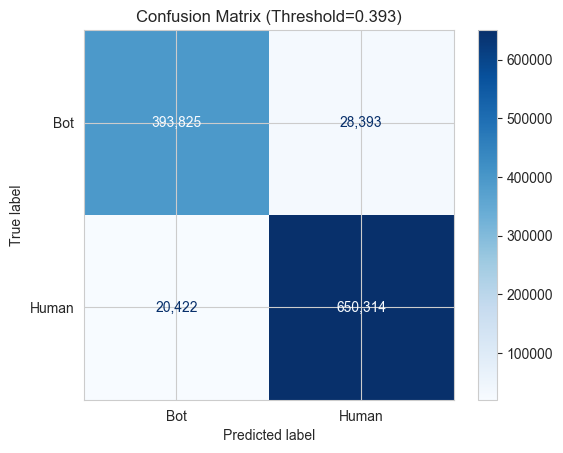

True Negatives: 393825
False Positives: 28393
False Negatives: 20422
True Positives: 650314


In [160]:
plot_confusion(y_test, metrics_lgb["y_pred"], metrics_lgb["best_thr"])

## Logit

In [161]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# === Train ===
logit = make_pipeline(
    StandardScaler(with_mean=True),
    LogisticRegression(
        penalty="elasticnet",
        l1_ratio=0.5,
        solver="saga",
        max_iter=3000,
        class_weight="balanced",
        random_state=42,
    ),
)

logit.fit(X_train, y_train)


,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.0


In [162]:
# === Predict ===
p_test_logit = logit.predict_proba(X_test)[:, 1]

# === Evaluate ===
metrics_logit = evaluate_model(y_test, p_test_logit)

ROC-AUC: 0.9501 | PR-AUC: 0.9674 | F1@0.370: 0.9037 | ACC: 0.8781


In [163]:
# === Results DF (uid index preserved) ===
results_logit = (
    pd.DataFrame({"P_bot": p_test_logit}, index=X_test.index)  # name kept to mirror your LGBM block
    .assign(
        y_true=y_test.values,
        y_pred=(p_test_logit >= metrics_logit["best_thr"]).astype(int),
    )
)

prob.name = "P_botartist"
results_logit = results_logit.join(prob, how="left")

results_logit.head()

,P_bot,y_true,y_pred,P_botartist
uid,,,,
uid8ff7d8a9497e61db3e3580321e91c9aa2ae4cff5c2e13b90a33a75b44a555a60,0.976639,1,1,9.800000e-07
uid41097f1d660cea56c86ff4e55a7fe39584be5a478ed575b037dffb25a0968d20,0.178808,1,0,7.300000e-07
uid824a7df18f17ac96e997b84aa0634e8f37e03a3ca662f1721a5614ae56c4aa6b,0.004957,0,0,9.900000e-07
uid844757b73d0920884725110208b4d645ab1ffad0d38959173125dae5b3dc06e7,0.215583,1,0,9.400000e-07
uidf951e43c2f96f58b7570af624001dc8428992077d85ce51f58b0145c4147527d,0.113158,0,0,9.400000e-07


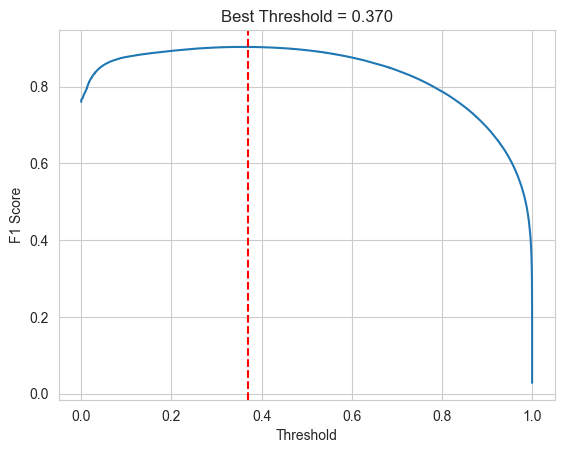

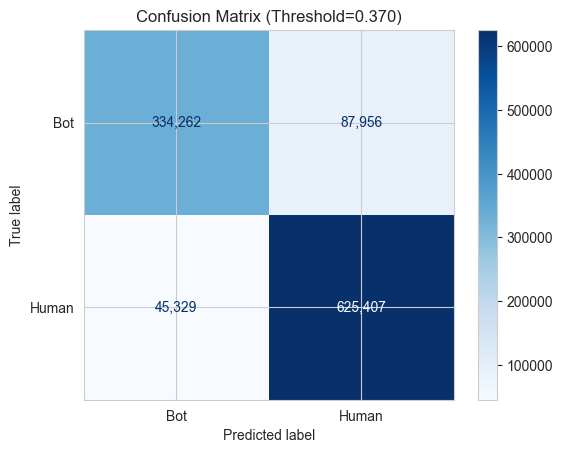

True Negatives: 334262
False Positives: 87956
False Negatives: 45329
True Positives: 625407


In [164]:
# === Plots ===
plot_threshold(metrics_logit["thr"], metrics_logit["best_thr"], metrics_logit["f1s"])
plot_confusion(y_test, metrics_logit["y_pred"], metrics_logit["best_thr"])


# Evalution

In [166]:
summary = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "ROC-AUC": metrics_logit["ROC-AUC"],
        "PR-AUC": metrics_logit["PR-AUC"],
        "F1": metrics_logit["F1"],
        "ACC": metrics_logit["ACC"],
        "Best Threshold": metrics_logit["best_thr"]
    },
    {
        "Model": "LightGBM",
        "ROC-AUC": metrics_lgb["ROC-AUC"],
        "PR-AUC": metrics_lgb["PR-AUC"],
        "F1": metrics_lgb["F1"],
        "ACC": metrics_lgb["ACC"],
        "Best Threshold": metrics_lgb["best_thr"]
    },
    {
        "Model": "HistGradientBoosting",
        "ROC-AUC": metrics_hgb["ROC-AUC"],
        "PR-AUC": metrics_hgb["PR-AUC"],
        "F1": metrics_hgb["F1"],
        "ACC": metrics_hgb["ACC"],
        "Best Threshold": metrics_hgb["best_thr"]
    }
])

summary = summary.set_index("Model").round(4)
summary

,ROC-AUC,PR-AUC,F1,ACC,Best Threshold
Model,,,,,
Logistic Regression,0.9501,0.9674,0.9037,0.8781,0.3704
LightGBM,0.9921,0.9951,0.9638,0.9553,0.3929
HistGradientBoosting,0.9864,0.9913,0.9495,0.9374,0.3995
